In [1]:
import scanpy as sc
import squidpy as sq
import anndata as ad
import schist as scs
import pandas as pd
%pylab 
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

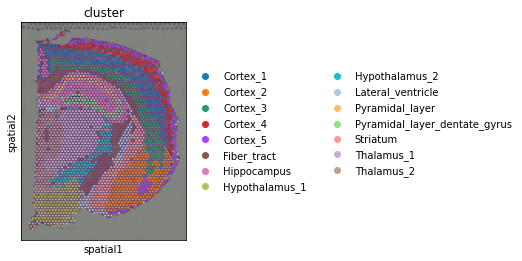

In [3]:
sc.pl.spatial(adata, color="cluster")

In [4]:
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img,
        features="summary",
        key_added=feature_name,
        n_jobs=1,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/2688 [00:00<?, ?/s]

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/2688 [00:00<?, ?/s]

In [6]:
adata.obsm['features'].filter(like='summary')

summary_ch-0_quantile-0.9  summary_ch-0_quantile-0.5  \
AAACAAGTATCTCCCA-1                      132.0                      111.0   
AAACAATCTACTAGCA-1                      140.0                      111.0   
AAACACCAATAACTGC-1                      132.0                      116.0   
AAACAGAGCGACTCCT-1                      136.0                      116.0   
AAACCGGGTAGGTACC-1                      137.0                      112.0   
...                                       ...                        ...   
TTGTTGTGTGTCAAGA-1                      135.0                      107.0   
TTGTTTCACATCCAGG-1                      139.0                      107.0   
TTGTTTCATTAGTCTA-1                      135.0                      111.0   
TTGTTTCCATACAACT-1                      136.0                      110.0   
TTGTTTGTGTAAATTC-1                      139.0                      115.0   

                    summary_ch-0_quantile-0.1  summary_ch-0_mean  \
AAACAAGTATCTCCCA-1                       77.0         107.571140   
AAACAATCTACTAGCA-1                       80.0         109.815175   
AAACACCAATAACTGC-1                       89.0         112.421285   
AAACAGAGCGACTCCT-1                       93.0         115.085217   
AAACCGGGTAGGTACC-1                       83.0         110.426840   
...                                       ...                ...   
TTGTTGTGTGTCAAGA-1                       45.0          98.505365   
TTGTTTCACATCCAGG-1                       64.0         104.259942   
TTGTTTCATTAGTCTA-1                       73.0         107.579220   
TTGTTTCCATACAACT-1                       77.0         107.720490   
TTGTTTGTGTAAATTC-1                       81.0         111.916930   

                    summary_ch-0_std  summary_ch-1_quantile-0.9  \
AAACAAGTATCTCCCA-1         21.767668                      102.0   
AAACAATCTACTAGCA-1         25.047208                       87.0   
AAACACCAATAACTGC-1         19.088559                      109.0   
AAACAGAGCGACTCCT-1         17.450778                      115.0   
AAACCGGGTAGGTACC-1         21.210674                      103.0   
...                              ...                        ...   
TTGTTGTGTGTCAAGA-1         33.255413                      104.0   
TTGTTTCACATCCAGG-1         28.099418                      112.0   
TTGTTTCATTAGTCTA-1         24.471029                      107.0   
TTGTTTCCATACAACT-1         23.502833                       99.0   
TTGTTTGTGTAAATTC-1         24.157025                      122.0   

                    summary_ch-1_quantile-0.5  summary_ch-1_quantile-0.1  \
AAACAAGTATCTCCCA-1                       79.0                       54.0   
AAACAATCTACTAGCA-1                       60.0                       39.0   
AAACACCAATAACTGC-1                       91.0                       67.0   
AAACAGAGCGACTCCT-1                       82.0                       58.0   
AAACCGGGTAGGTACC-1                       78.0                       54.0   
...                                       ...                        ...   
TTGTTGTGTGTCAAGA-1                       74.0                       33.0   
TTGTTTCACATCCAGG-1                       81.0                       49.0   
TTGTTTCATTAGTCTA-1                       81.0                       54.0   
TTGTTTCCATACAACT-1                       73.0                       49.0   
TTGTTTGTGTAAATTC-1                       93.0                       62.0   

                    summary_ch-1_mean  summary_ch-1_std  ...  \
AAACAAGTATCTCCCA-1          78.586668         19.153915  ...   
AAACAATCTACTAGCA-1          61.846105         19.495044  ...   
AAACACCAATAACTGC-1          89.382780         16.884106  ...   
AAACAGAGCGACTCCT-1          84.919202         22.004344  ...   
AAACCGGGTAGGTACC-1          78.434920         19.046626  ...   
...                               ...               ...  ...   
TTGTTGTGTGTCAAGA-1          71.122964         26.024651  ...   
TTGTTTCACATCCAGG-1          80.879687         24.025899  ...

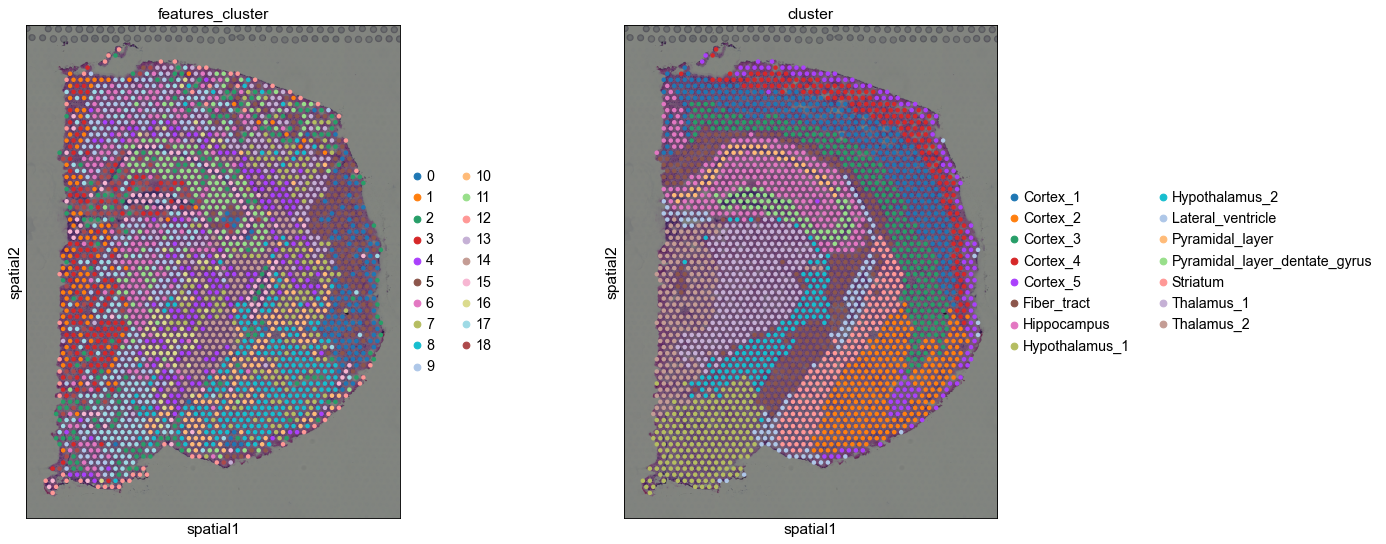

In [7]:
def cluster_features(features: pd.DataFrame, like=None):
    """Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    scs.inference.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "cluster"])

In [8]:
scs.inference.nested_model(adata)

In [9]:
features = adata.obsm['features'].filter(like='summary')
fdata = ad.AnnData(features)
sc.pp.scale(fdata)
sc.pp.pca(fdata, n_comps=min(10, features.shape[1] - 1))
sc.pp.neighbors(fdata, n_neighbors=int(np.sqrt(fdata.shape[0])/2))
scs.inference.nested_model(fdata)

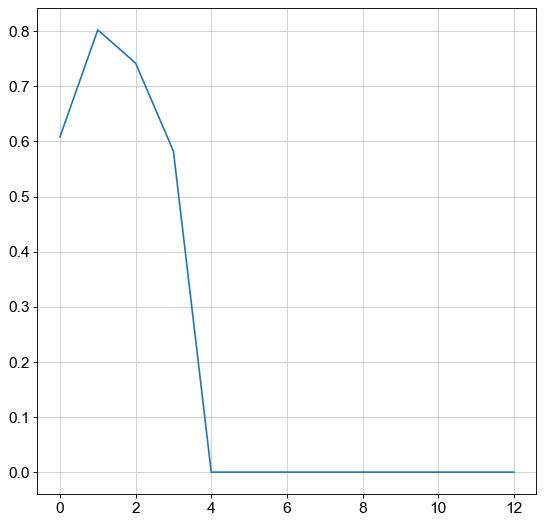

In [10]:
plot(adata.uns['schist']['stats']['modularity'])

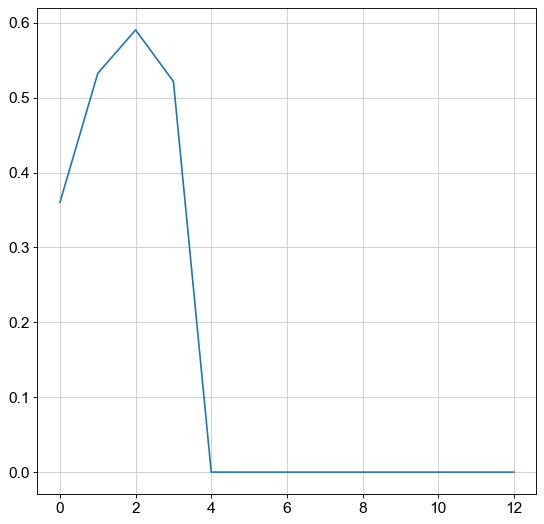

In [11]:
plot(fdata.uns['schist']['stats']['modularity'])

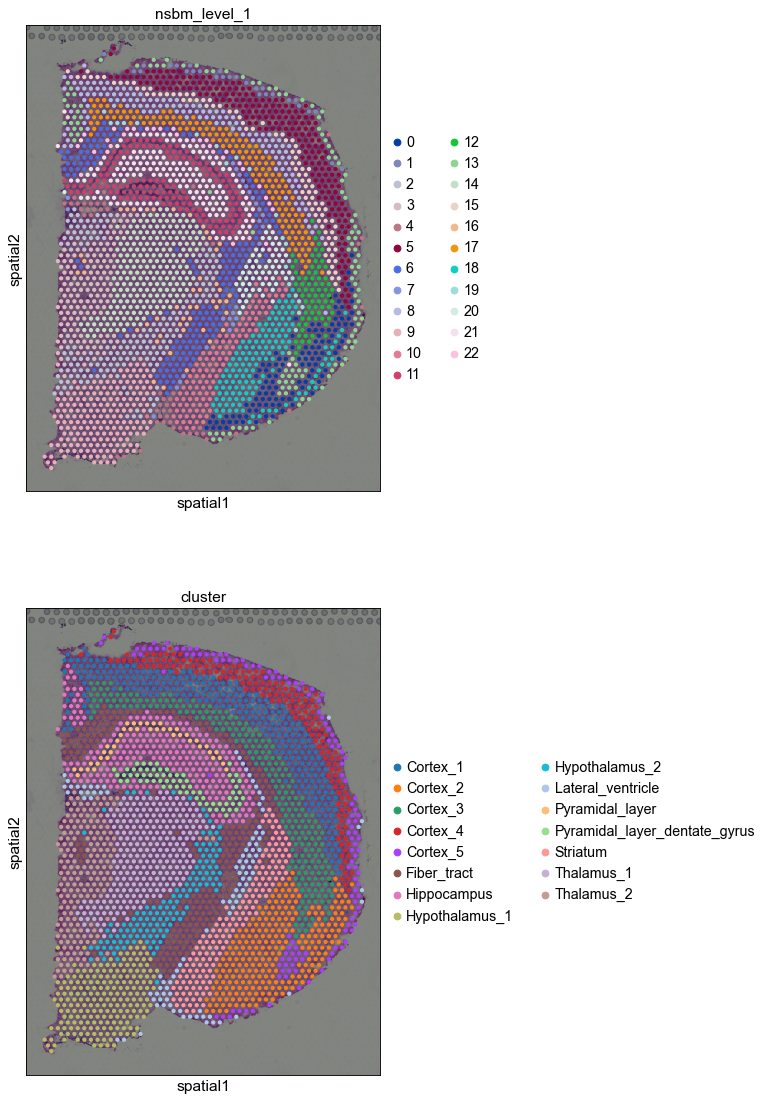

In [38]:
sc.pl.spatial(adata, color=['nsbm_level_1', 'cluster'], ncols=1) 

In [13]:
scs.inference.leiden(adata, key_added='gene_leiden')

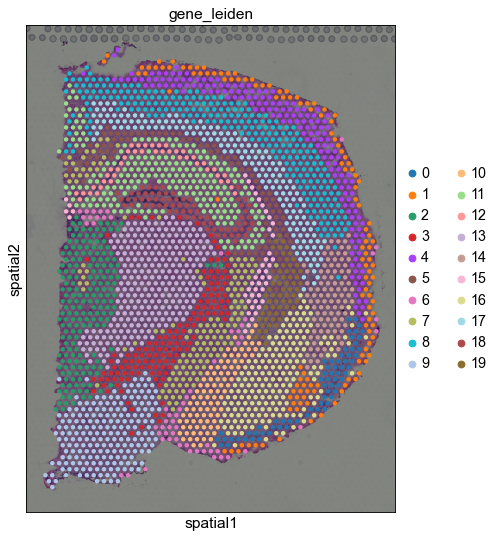

In [14]:
sc.pl.spatial(adata, color='gene_leiden') 

In [50]:
scs.inference.leiden(adata, key_added='leiden_r05', resolution=0.5)

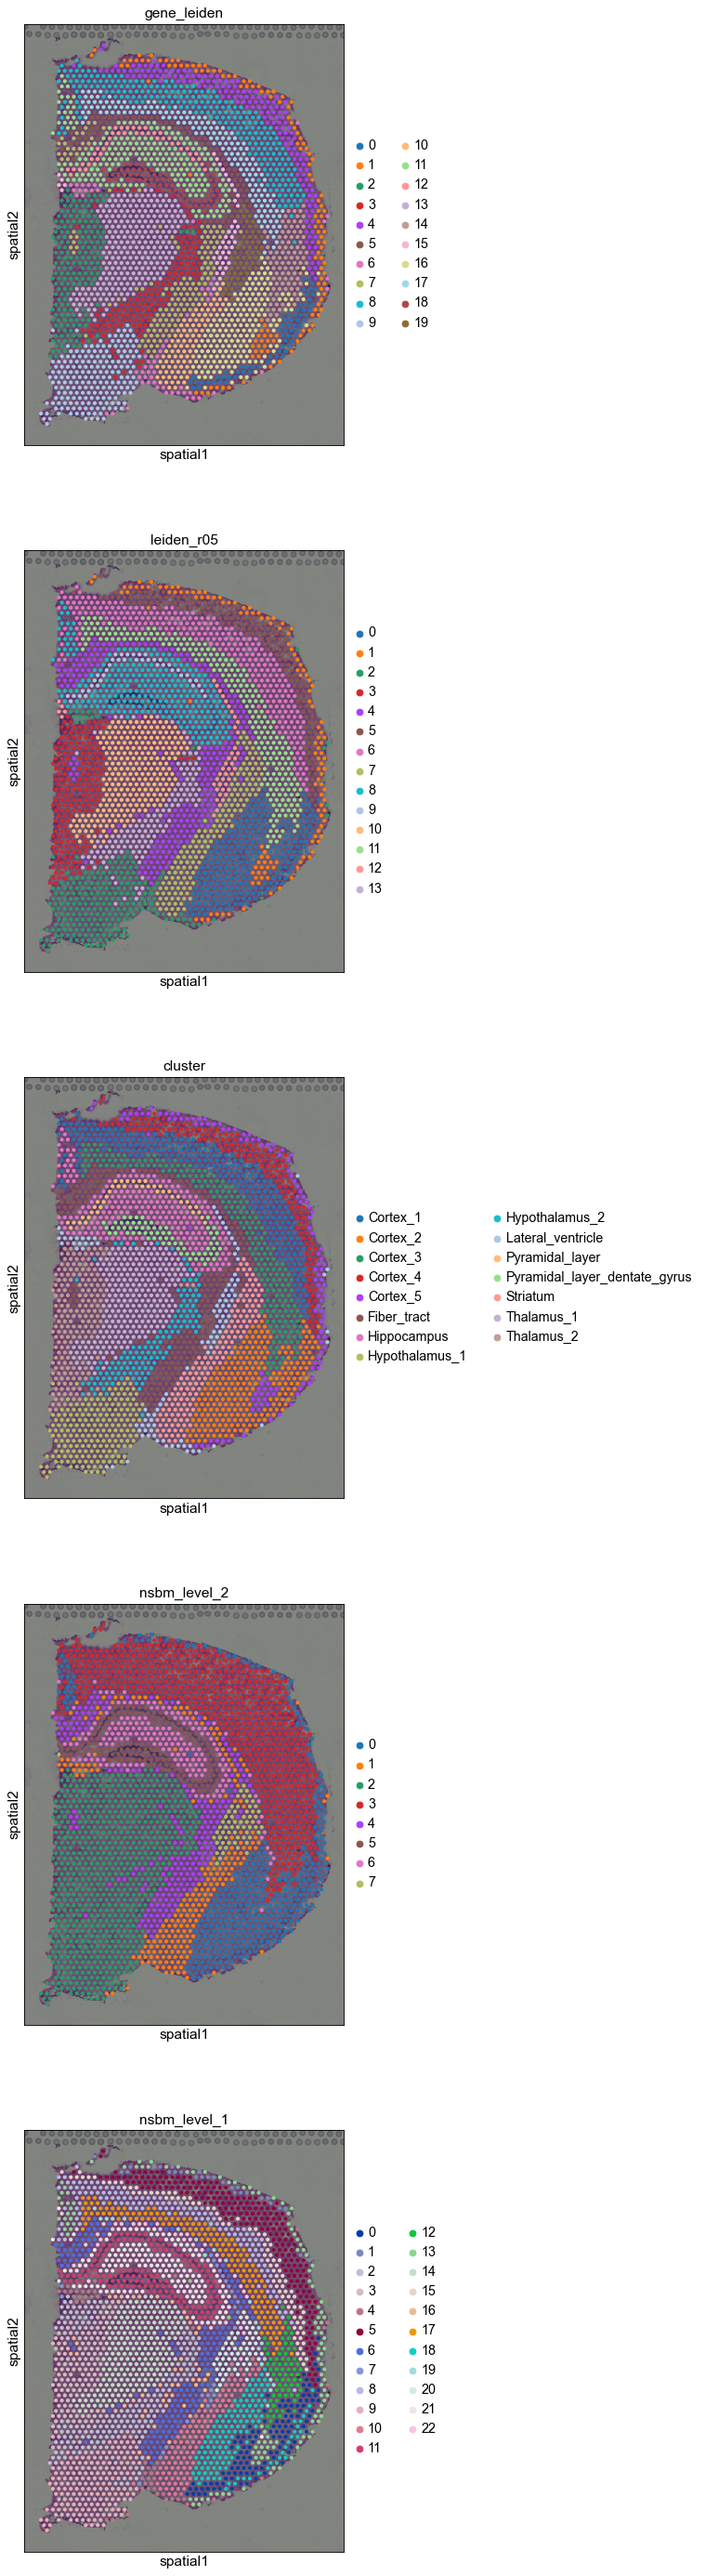

In [53]:
sc.pl.spatial(adata, color=['gene_leiden','leiden_r05', 'cluster','nsbm_level_2', 'nsbm_level_1'], ncols=1) 

In [55]:
scs.io.write(adata, 'visium')

In [56]:
adata.obs['feature_nsbm_level_3'] = fdata.obs['nsbm_level_3']

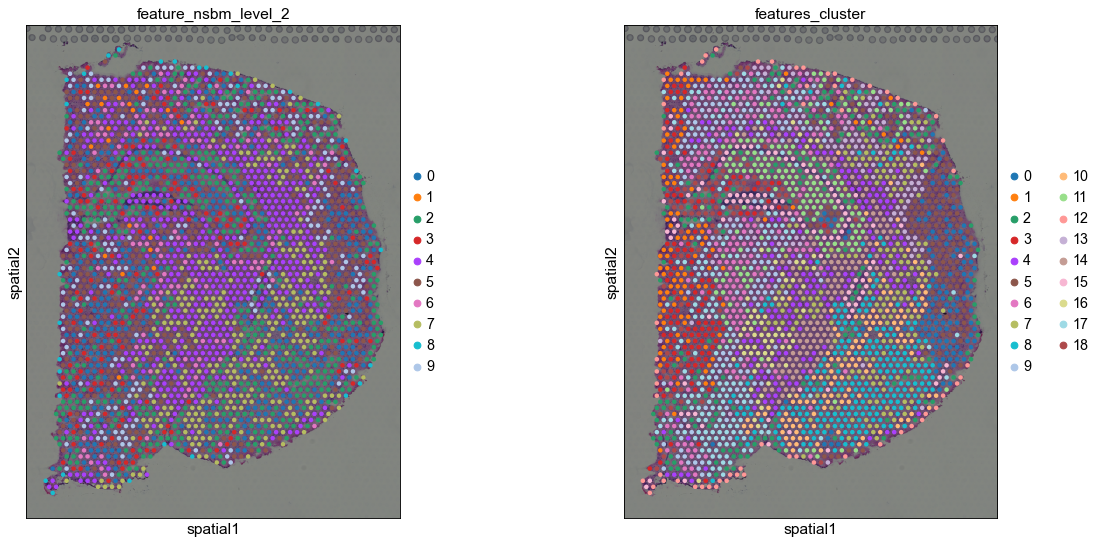

In [63]:
sc.pl.spatial(adata, color=['feature_nsbm_level_2', 'features_cluster'])

In [64]:
scs.inference.planted_model(adata)

In [65]:
scs.inference.planted_model(fdata)

In [2]:
img = sq.datasets.visium_hne_image()
adata = scs.io.read('visium')


/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


In [3]:
sc.set_figure_params(dpi_save=300)

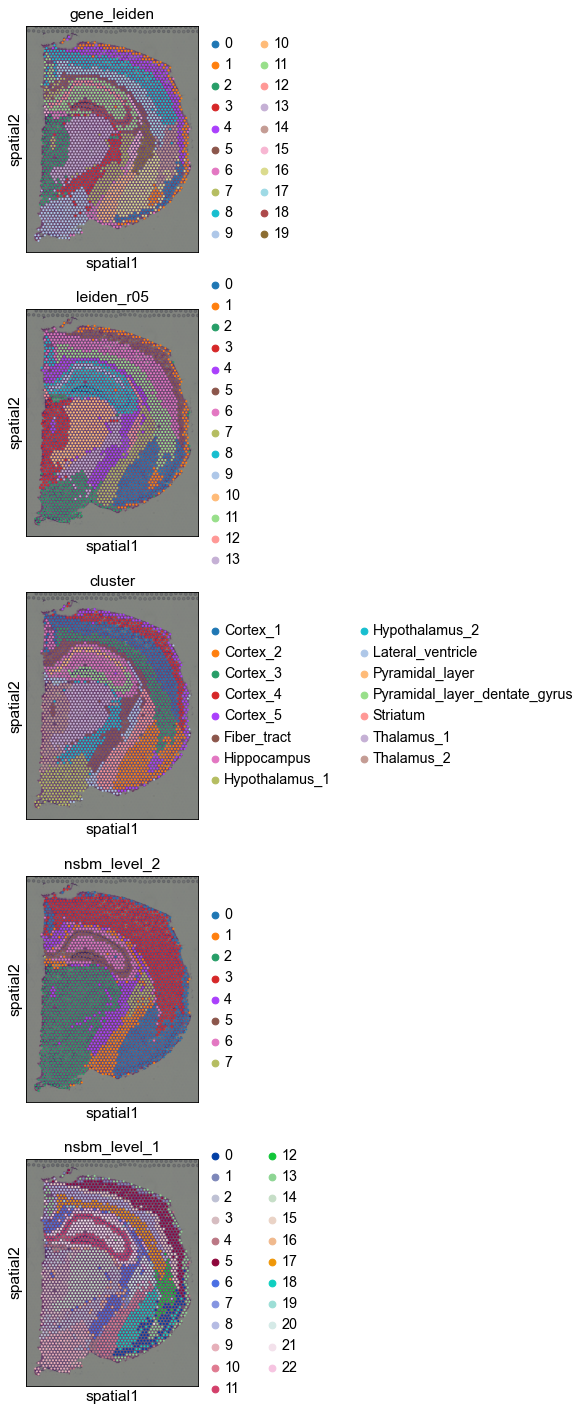

In [4]:
sc.pl.spatial(adata, color=['gene_leiden','leiden_r05', 'cluster','nsbm_level_2', 'nsbm_level_1'], ncols=1) 

<ipython-input-19-f3d5574f3abc>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


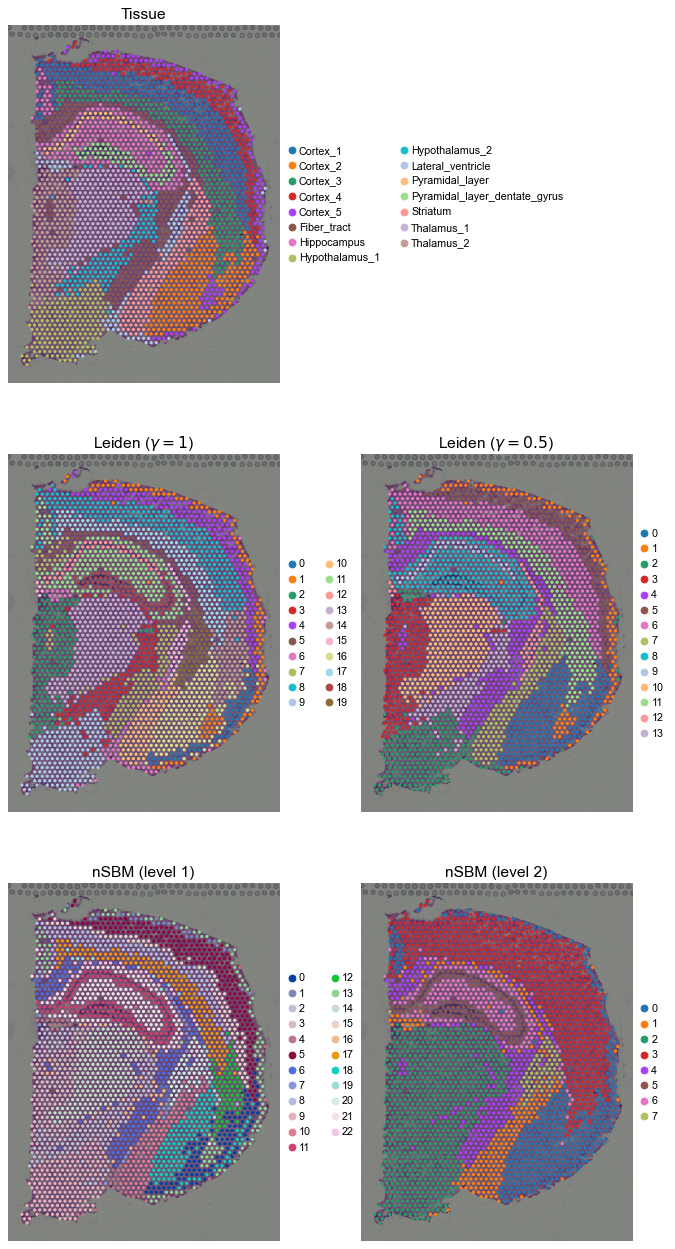

In [19]:
fig = plt.figure(constrained_layout=False, figsize=(10, 20))
gs = fig.add_gridspec(nrows=3, ncols=2, wspace=0.3)

ax1=fig.add_subplot(gs[0, 0])
ax2=fig.add_subplot(gs[1, 0])
ax3=fig.add_subplot(gs[1, 1])
ax4=fig.add_subplot(gs[2, 0])
ax5=fig.add_subplot(gs[2, 1])

sc.pl.spatial(adata, color='cluster', ncols=1, frameon=False, 
              title='Tissue', ax=ax1, show=False,
              legend_fontsize='x-small')
sc.pl.spatial(adata, color='gene_leiden', ncols=1, frameon=False, 
              title='Leiden ($\gamma=1$)', ax=ax2, show=False,
              legend_fontsize='x-small')
sc.pl.spatial(adata, color='leiden_r05', ncols=1, frameon=False, 
              title='Leiden ($\gamma=0.5$)',ax=ax3,show=False,
              legend_fontsize='x-small')
sc.pl.spatial(adata, color='nsbm_level_1', ncols=1, frameon=False, 
              title='nSBM (level 1)',ax=ax4, show=False,
              legend_fontsize='x-small')
sc.pl.spatial(adata, color='nsbm_level_2', ncols=1, frameon=False, 
              title='nSBM (level 2)',ax=ax5, show=False,
              legend_fontsize='x-small')

plt.tight_layout()
plt.show()
fig.savefig('Figure_Visium_Spatial.pdf', dpi=300, transparent=True)

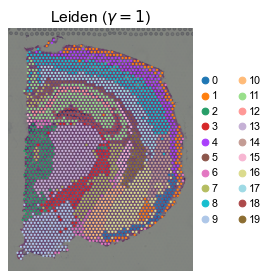

In [11]:
sc.pl.spatial(adata, color=['gene_leiden'], ncols=1, frameon=False, 
              title='Leiden ($\gamma=1$)',
              legend_fontsize='x-small',
              save='Visium_Leiden_1.png') 


In [27]:
adata.obs['cluster'].cat.rename_categories([x.replace('_', ' ') for x in adata.obs['cluster'].cat.categories], inplace=True)

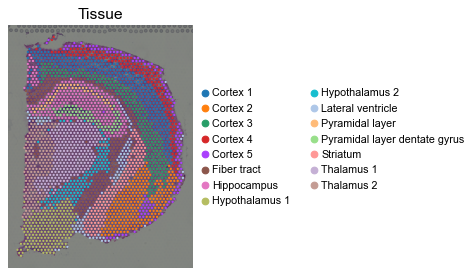

In [28]:
sc.pl.spatial(adata, color=['cluster'], ncols=1, frameon=False, 
              title='Tissue', 
              legend_fontsize='x-small',
             save='Visium_Tissue.png') 

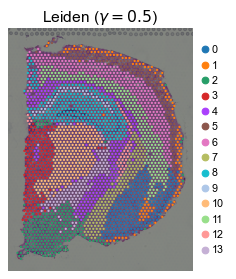

In [13]:
sc.pl.spatial(adata, color=['leiden_r05'], ncols=1, frameon=False, 
              title='Leiden ($\gamma=0.5$)',
              legend_fontsize='x-small',
              save='Visium_Leiden_0.5.png') 



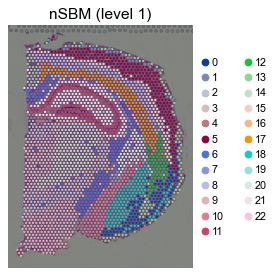

In [14]:
sc.pl.spatial(adata, color=['nsbm_level_1'], ncols=1, frameon=False, 
              title='nSBM (level 1)',
              legend_fontsize='x-small',
              save='Visium_nsbm_1.png') 




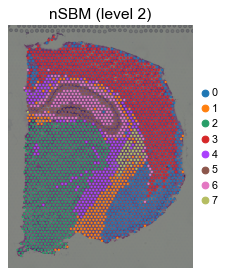

In [15]:
sc.pl.spatial(adata, color=['nsbm_level_2'], ncols=1, frameon=False, 
              title='nSBM (level 2)',
              legend_fontsize='x-small',
              save='Visium_nsbm_2.png') 





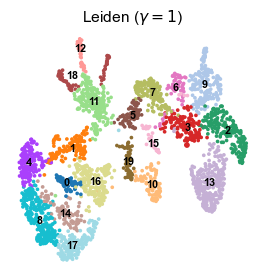

In [21]:
sc.pl.umap(adata, color=['gene_leiden'], ncols=1, frameon=False, 
              title='Leiden ($\gamma=1$)',
              legend_fontsize='x-small', legend_loc='on data',
              save='Visium_Leiden_1.png') 



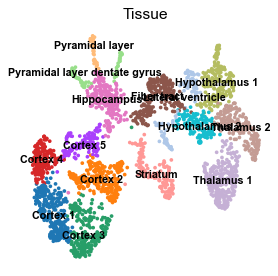

In [29]:
sc.pl.umap(adata, color=['cluster'], ncols=1, frameon=False, 
              title='Tissue', 
              legend_fontsize='x-small', legend_loc='on data',
             save='Visium_Tissue.png') 

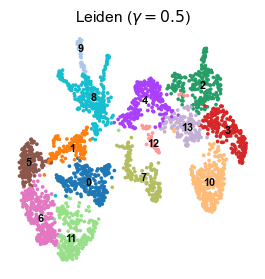

In [23]:
sc.pl.umap(adata, color=['leiden_r05'], ncols=1, frameon=False, 
              title='Leiden ($\gamma=0.5$)',
              legend_fontsize='x-small', legend_loc='on data',
              save='Visium_Leiden_0.5.png') 




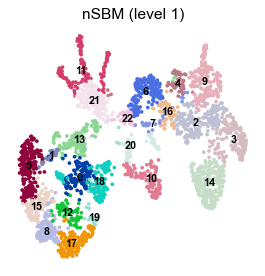

In [24]:
sc.pl.umap(adata, color=['nsbm_level_1'], ncols=1, frameon=False, 
              title='nSBM (level 1)',
              legend_fontsize='x-small', legend_loc='on data',
              save='Visium_nsbm_1.png') 





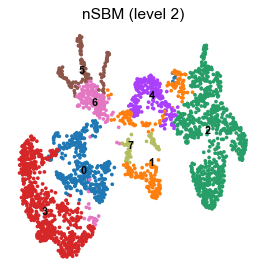

In [25]:
sc.pl.umap(adata, color=['nsbm_level_2'], ncols=1, frameon=False, 
              title='nSBM (level 2)',
              legend_fontsize='x-small', legend_loc='on data',
              save='Visium_nsbm_2.png') 






In [31]:
g = adata.uns['schist']['state'].g

In [32]:
import graph_tool.all as gt

In [36]:
for G in ['leiden', 'leiden_r05', 'nsbm_level_1', 'nsbm_level_2']:
    B = gt.BlockState(g, b=adata.obs[G].cat.codes.values)
    print(G, gt.modularity(g, B.get_blocks()))

leiden 0.8375556987798239
leiden_r05 0.8362981901813044
nsbm_level_1 0.8023282638794932
nsbm_level_2 0.7421111724696323


### Revision

In [2]:
adata = scs.io.read('visium')

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


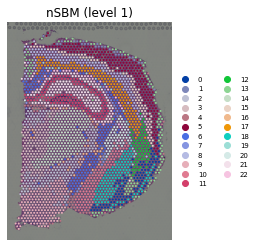

In [3]:
sc.pl.spatial(adata, color=['nsbm_level_1'], ncols=1, frameon=False, 
              title='nSBM (level 1)',
              legend_fontsize='x-small')





In [4]:
pd.crosstab(adata.obs['cluster'], adata.obs['nsbm_level_1'])

nsbm_level_1                     0   1    2    3   4    5    6   7    8    9  \
cluster                                                                        
Cortex_1                         0   0    0    0   0   55    0   0  132    0   
Cortex_2                       110   0    0    0   0    0    0   0    0    0   
Cortex_3                         2   0    0    0   0    0    0   0    3    0   
Cortex_4                         2   5    0    0   0  157    0   0    0    0   
Cortex_5                         3  23    0    0   0    1    0   0    0    0   
Fiber_tract                      0   0    0    1   0    0  171   1    0    0   
Hippocampus                      0   0    0    0   3    0    0   0    1    0   
Hypothalamus_1                   0   0    9    0   0    0    0   0    0  198   
Hypothalamus_2                   0   0  107    0   0    0    0   0    0    0   
Lateral_ventricle                0   0    1    0  46    0    0  26    0    0   
Pyramidal_layer                  0   0    0    0   0    0    0   0    0    0   
Pyramidal_layer_dentate_gyrus    0   0    0    0   0    0    0   0    0    0   
Striatum                         0   0    0    0   0    0    0   0    0    0   
Thalamus_1                       0   0    0   27   0    0    0   0    0    0   
Thalamus_2                       0   0   73  119   0    0    0   0    0    0   

nsbm_level_1                   ...   13   14  15  16   17   18  19  20   21  \
cluster                        ...                                            
Cortex_1                       ...    0    0  94   0    0    0   0   0    0   
Cortex_2                       ...    1    0   0   0    0  143   2   0    0   
Cortex_3                       ...    0    0   0   0  153    0  17   0    0   
Cortex_4                       ...    0    0   0   0    0    0   0   0    0   
Cortex_5                       ...  101    0   0   0    0    0   0   0    1   
Fiber_tract                    ...    0    0   0  20    0    0   0   0    0   
Hippocampus                    ...   20    0   0   0    0    0   1   0  164   
Hypothalamus_1                 ...    0    0   0   0    0    0   0   0    0   
Hypothalamus_2                 ...    0    0   0  26    0    0   0   0    0   
Lateral_ventricle              ...    4    0   0   0    0    0   0  28    0   
Pyramidal_layer                ...    0    0   0   0    0    0   0   0    0   
Pyramidal_layer_dentate_gyrus  ...    0    0   0   0    0    0   0   0    0   
Striatum                       ...    0    0   0   0    0    1   2  34    0   
Thalamus_1                     ...    0  234   0   0    0    0   0   0    0   
Thalamus_2                     ...    0    0   0   0    0    0   0   0    0   

nsbm_level_1                   22  
cluster                            
Cortex_1                        0  
Cortex_2                        0  
Cortex_3                        0  
Cortex_4                        0  
Cortex_5                        0  
Fiber_tract                    33  
Hippocampus                     2  
Hypothalamus_1                  0  
Hypothalamus_2                  0  
Lateral_ventricle               0  
Pyramidal_layer                 0  
Pyramidal_layer_dentate_gyrus   0  
Striatum                        0  
Thalamus_1                      0  
Thalamus_2                      0  

[15 rows x 23 columns]

In [5]:
pd.crosstab(adata.obs['cluster'], adata.obs['nsbm_level_2'])

nsbm_level_2                     0    1    2    3    4   5    6   7
cluster                                                            
Cortex_1                         0    0    0  284    0   0    0   0
Cortex_2                       254    1    0    0    0   0    2   0
Cortex_3                         2    0    0  225    0   0   17   0
Cortex_4                         2    0    0  162    0   0    0   0
Cortex_5                       104    0    0   24    0   0    1   0
Fiber_tract                      0   34    1    0  191   0    0   0
Hippocampus                     20    5    0    1    0  31  165   0
Hypothalamus_1                   0    1  207    0    0   0    0   0
Hypothalamus_2                   0    0  107    0   26   0    0   0
Lateral_ventricle                4   72    1    0    0   0    0  28
Pyramidal_layer                  0    0    0    0    0  42    0   0
Pyramidal_layer_dentate_gyrus    0    0    0    0    0  68    0   0
Striatum                         1  116    0    0    0   0    2  34
Thalamus_1                       0    0  261    0    0   0    0   0
Thalamus_2                       0    0  192    0    0   0    0   0

In [27]:
pd.crosstab(adata.obs['cluster'], adata.obs['nsbm_level_2'])['2'].sort_values()

cluster
Cortex_1                           0
Cortex_2                           0
Cortex_3                           0
Cortex_4                           0
Cortex_5                           0
Hippocampus                        0
Pyramidal_layer                    0
Pyramidal_layer_dentate_gyrus      0
Striatum                           0
Fiber_tract                        1
Lateral_ventricle                  1
Hypothalamus_2                   107
Thalamus_2                       192
Hypothalamus_1                   207
Thalamus_1                       261
Name: 2, dtype: int64

In [26]:
pd.crosstab(adata.obs['cluster'], adata.obs['leiden_r05'])[['2']]

leiden_r05                       2
cluster                           
Cortex_1                         0
Cortex_2                         0
Cortex_3                         0
Cortex_4                         0
Cortex_5                         0
Fiber_tract                      0
Hippocampus                      0
Hypothalamus_1                 201
Hypothalamus_2                   0
Lateral_ventricle               51
Pyramidal_layer                  0
Pyramidal_layer_dentate_gyrus    0
Striatum                         0
Thalamus_1                       0
Thalamus_2                       0

In [8]:
import sklearn.metrics

In [33]:
sklearn.metrics.adjusted_rand_score(adata.obs['cluster'], adata.obs['leiden_r05'])

0.9347962519154615

In [34]:
sklearn.metrics.adjusted_rand_score(adata.obs['cluster'], adata.obs['gene_leiden'])

0.8766902235355299

In [35]:
sklearn.metrics.adjusted_rand_score(adata.obs['cluster'], adata.obs['nsbm_level_1'])

0.6753089122382371

In [17]:
sc.set_figure_params(dpi_save=300)

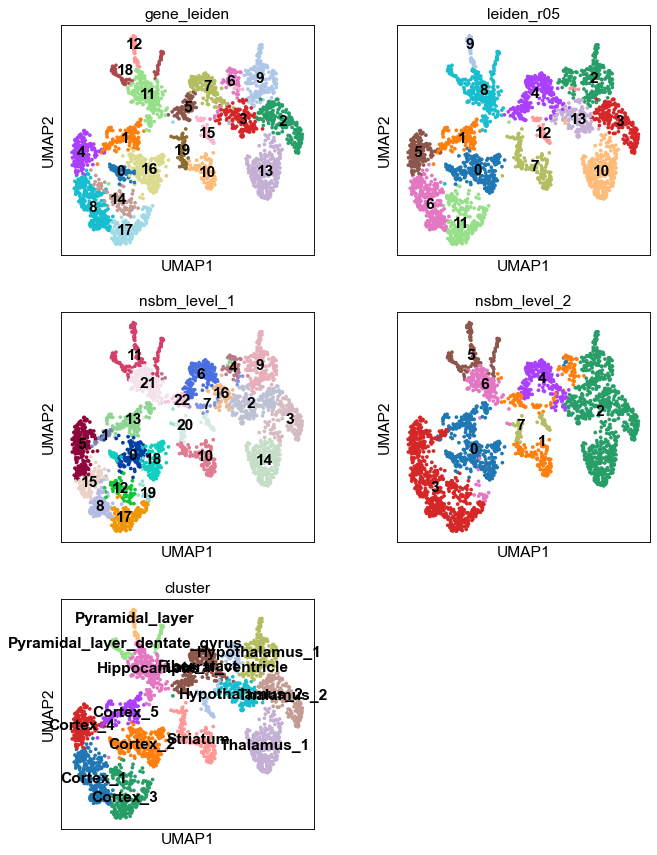

In [21]:
sc.pl.umap(adata,color=['gene_leiden', 'leiden_r05', 'nsbm_level_1', 'nsbm_level_2', 'cluster'],ncols=2, legend_loc='on data')

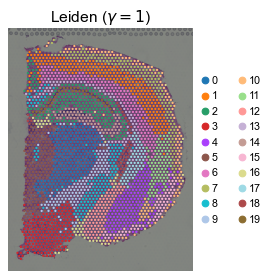

In [20]:
sc.pl.spatial(adata, color=['leiden'], ncols=1, frameon=False, 
              title='Leiden ($\gamma=1$)',
              legend_fontsize='x-small')


In [50]:
pd.crosstab(adata.obs['cluster'], adata.obs['nsbm_level_0']).T['Pyramidal_layer_dentate_gyrus'].sort_values()

nsbm_level_0
0       0
70      0
69      0
68      0
67      0
       ..
100     0
89      6
80     18
85     21
42     23
Name: Pyramidal_layer_dentate_gyrus, Length: 101, dtype: int64

In [41]:
pd.crosstab(adata.obs['cluster'], adata.obs['nsbm_level_0'])[['17', '73']].sum(axis=1).sort_values()

cluster
Cortex_1                          0
Cortex_2                          0
Cortex_3                          0
Cortex_4                          0
Cortex_5                          0
Fiber_tract                       0
Hypothalamus_1                    0
Hypothalamus_2                    0
Lateral_ventricle                 0
Pyramidal_layer_dentate_gyrus     0
Striatum                          0
Thalamus_1                        0
Thalamus_2                        0
Hippocampus                       1
Pyramidal_layer                  42
dtype: int64

In [45]:
adata.obs['cluster'].value_counts()

Cortex_1                         284
Thalamus_1                       261
Cortex_2                         257
Cortex_3                         244
Fiber_tract                      226
Hippocampus                      222
Hypothalamus_1                   208
Thalamus_2                       192
Cortex_4                         164
Striatum                         153
Hypothalamus_2                   133
Cortex_5                         129
Lateral_ventricle                105
Pyramidal_layer_dentate_gyrus     68
Pyramidal_layer                   42
Name: cluster, dtype: int64

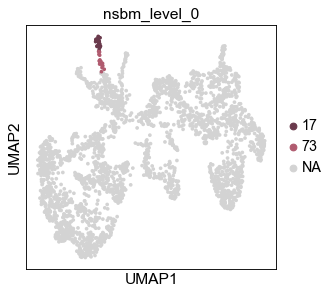

In [49]:
sc.pl.umap(adata, color='nsbm_level_0', groups=['17', '73'])

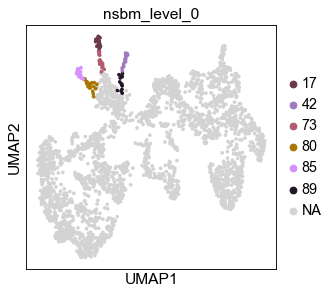

In [52]:
sc.pl.umap(adata, color='nsbm_level_0', groups=['17', '73','89', '80','85', '42'])

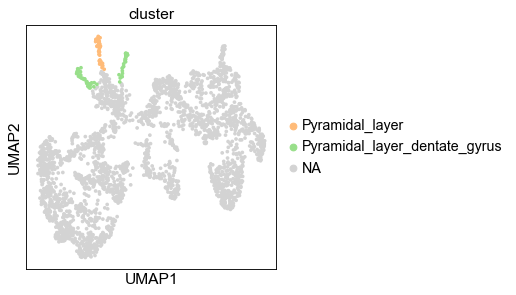

In [53]:
sc.pl.umap(adata, color='cluster', groups=['Pyramidal_layer','Pyramidal_layer_dentate_gyrus'])

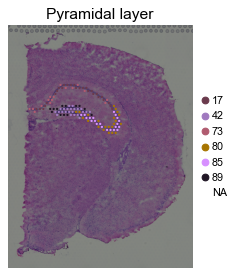

In [55]:
sc.pl.spatial(adata, color=['nsbm_level_0'], ncols=1, frameon=False, 
              title='Pyramidal layer', groups=['17', '73','89', '80','85', '42'],
              legend_fontsize='x-small')

